# Fetching Data from PubMed (Entrez API)

In [5]:
import os
import pandas as pd
import time
import random
from Bio import Entrez
from urllib.error import HTTPError

# Set your email for NCBI Entrez API
Entrez.email = "your_email@example.com"

# CSV files with diseases output from CTD-ID:
# python Python/main_gba.py --adj_path ../data/target_disease/cor_matrix_99.csv --s_nodes ../data/target_disease/ad_cor_20.csv
# python Python/main_gba.py --adj_path ../data/target_disease/cor_matrix_99.csv --s_nodes ../data/target_disease/childhoodcancer_cor_20.csv
# python Python/main_gba.py --adj_path ../data/target_disease/cor_matrix_99.csv --s_nodes ../data/target_disease/chd_cor_20.csv
gba_ranks_files = {
    'Alzheimer\'s disease': '../data/target_disease/nolit/ad_cor_20_no_lit_small_0.968_gba_ranks.csv',
    'Childhood cancer': '../data/target_disease/nolit/childhoodcancer_cor_20_no_lit_small_0.977_gba_ranks.csv',
    'Congenital heart disease': '../data/target_disease/nolit/chd_cor_20_no_lit_0.798_gba_ranks.csv'
}

s_files = {
    'Alzheimer\'s disease': '../data/target_disease/nolit/ad_cor_20_no_lit_small.csv',
    'Childhood cancer': '../data/target_disease/nolit/childhoodcancer_cor_20_no_lit_small.csv',
    'Congenital heart disease': '../data/target_disease/nolit/chd_cor_20_no_lit.csv'
}

all_files = [s_files, gba_ranks_files, gba_ranks_files]
subset = ['Disease_module', 'Top', 'Random']

TOP_DISEASE_NUM = 1000

# Function to search PubMed with retries
def search_pubmed_with_retry(disease1, disease2="childhood cancer", max_results=20_000, retries=5, delay=0.5):
    query = f"{disease1} AND {disease2}"
    
    for attempt in range(retries):
        try:
            handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
            record = Entrez.read(handle)
            handle.close()
            num_articles = len(record["IdList"])
            print(f"🔍 {disease1}: Found {num_articles} articles.")
            return num_articles
        
        except HTTPError as e:
            print(f"⚠️ HTTPError for query '{query}': {e}. Retrying in {delay} seconds...")
        except Exception as e:
            print(f"⚠️ Unexpected error for query '{query}': {e}. Retrying in {delay} seconds...")
        
        time.sleep(delay)
        delay *= 2  # Exponential backoff
    
    print(f"❌ Failed to fetch results for '{query}' after {retries} retries.")
    return 0  # Return 0 if all retries fail

# Fetch PubMed Data and Save to CSV
for csv_files, info in zip(all_files, subset):
    for explored_disease, path in csv_files.items():
        # Read first column (disease names)
        df = pd.read_csv(path, usecols=[0])
        if info == 'Disease_module':
            disease_list = df.iloc[:, 0].dropna().tolist()
        elif info == 'Top':
            disease_list = df.iloc[:, 0].dropna().tolist()[:TOP_DISEASE_NUM]
        else:  # Random subset
            disease_list = df.iloc[:, 0].dropna().tolist()[100:]
            disease_list = random.sample(disease_list, min(TOP_DISEASE_NUM, len(disease_list)))

        # Format disease names
        disease_list = [x.replace('_', ' ').replace('.', ' ') for x in disease_list]

        # Query PubMed for each disease
        results = []
        for disease in disease_list:
            num_articles = search_pubmed_with_retry(disease, explored_disease)
            results.append({"Disease": disease, "Articles": num_articles})
            time.sleep(0.3)  # Sleep to prevent rate limiting

        # Convert to DataFrame and save results
        df_results = pd.DataFrame(results)
        df_results.to_csv(f"{explored_disease.replace(' ', '_')}_pubmed_results_nolit_{info}.csv", index=False)

print("✅ Data fetching complete. CSV files saved.")


🔍 Parkinson disease: Found 9999 articles.
🔍 multiple sclerosis: Found 5108 articles.
🔍 infection: Found 7514 articles.
🔍 neoplasm: Found 5129 articles.
🔍 Cognitive impairment: Found 9999 articles.
🔍 cancer: Found 9999 articles.
🔍 insulin resistance: Found 2183 articles.
🔍 Stroke: Found 9999 articles.
🔍 Sepsis: Found 289 articles.
🔍 atherosclerosis: Found 2102 articles.
🔍 breast cancer: Found 877 articles.
🔍 Obesity: Found 2869 articles.
🔍 Huntington disease: Found 5478 articles.
🔍 diabetes mellitus: Found 4828 articles.
🔍 myeloid sarcoma: Found 2 articles.
🔍 ischemia: Found 3959 articles.
🔍 melanoma: Found 193 articles.
🔍 Rheumatoid arthritis: Found 670 articles.
🔍 chronic obstructive pulmonary disease: Found 344 articles.
🔍 Insulin resistance: Found 2183 articles.
🔍 major salivary gland cancer: Found 21 articles.
🔍 functioning pituitary gland adenoma: Found 494 articles.
🔍 diffuse intrinsic pontine glioma: Found 149 articles.
🔍 Menstrual disorder: Found 65 articles.
🔍 hematopoietic an

🔍 mucous membrane pemphigoid: Found 1 articles.
🔍 Hyperglycemia: Found 570 articles.
🔍 lung adenocarcinoma: Found 37 articles.
🔍 acute lung injury: Found 45 articles.
🔍 in situ carcinoma: Found 12 articles.
🔍 long COVID 19: Found 0 articles.
🔍 influenza: Found 238 articles.
🔍 head and neck malignant neoplasia: Found 24 articles.
🔍 sarcoidosis: Found 22 articles.
🔍 Hyperinsulinemia: Found 1172 articles.
🔍 colorectal neoplasm: Found 182 articles.
🔍 oral squamous cell carcinoma: Found 21 articles.
🔍 osteosarcoma: Found 21 articles.
🔍 ovarian cancer: Found 149 articles.
🔍 Vitiligo: Found 14 articles.
🔍 acute myocardial infarction: Found 111 articles.
🔍 synovial sarcoma: Found 1 articles.
🔍 gastric cancer: Found 160 articles.
🔍 Parkinsonism: Found 9999 articles.
🔍 esophageal squamous cell carcinoma: Found 3 articles.
🔍 lymph node metastatic carcinoma: Found 5 articles.
🔍 urinary bladder carcinoma: Found 5 articles.
🔍 posterior cortical atrophy: Found 935 articles.
🔍 Diabetes mellitus: Found

🔍 AIDS: Found 977 articles.
🔍 meningioma: Found 45 articles.
🔍 laryngotracheoesophageal cleft: Found 0 articles.
🔍 rectum cancer: Found 13 articles.
🔍 skin squamous cell carcinoma: Found 12 articles.
🔍 cyst: Found 9999 articles.
🔍 substance dependence: Found 687 articles.
🔍 pulmonary tuberculosis: Found 24 articles.
🔍 cocaine dependence: Found 18 articles.
🔍 ovarian serous adenocarcinoma: Found 1 articles.
🔍 arteriosclerosis: Found 4480 articles.
🔍 Onset: Found 9999 articles.
🔍 heart disease: Found 6090 articles.
🔍 Infantile dystonia parkinsonism: Found 1 articles.
🔍 squamous cell lung carcinoma: Found 23 articles.
🔍 spindle cell hemangioma: Found 0 articles.
🔍 alcohol dependence: Found 484 articles.
🔍 kidney neoplasm: Found 119 articles.
🔍 SATB2 associated disorder: Found 2 articles.
🔍 alcoholic fatty liver disease: Found 155 articles.
🔍 liver and intrahepatic bile duct neoplasm: Found 0 articles.
🔍 Acute Leukemia: Found 84 articles.
🔍 coinfection: Found 23 articles.
🔍 emphysema: Foun

🔍 allergic asthma: Found 39 articles.
🔍 Thymoma: Found 13 articles.
🔍 HER2 Positive Breast Carcinoma: Found 1 articles.
🔍 carcinoma of liver and intrahepatic biliary tract: Found 0 articles.
🔍 Duodenal Adenocarcinoma: Found 2 articles.
🔍 endometrioid carcinoma: Found 1 articles.
🔍 uterine corpus endometrial carcinoma: Found 0 articles.
🔍 Spinal Cord Ischemia: Found 112 articles.
🔍 oral cavity carcinoma: Found 10 articles.
🔍 Escherichia coli Infections: Found 18 articles.
🔍 pulpitis: Found 3 articles.
🔍 Creutzfeldt Jacob Disease: Found 829 articles.
🔍 acute promyelocytic leukemia: Found 8 articles.
🔍 ischemic cardiomyopathy: Found 44 articles.
🔍 retinal ischemia: Found 62 articles.
🔍 bile duct adenocarcinoma: Found 0 articles.
🔍 chronic hepatitis C virus infection: Found 6 articles.
🔍 visceral Leishmaniasis: Found 1 articles.
🔍 B cell acute lymphoblastic leukemia: Found 2 articles.
🔍 undifferentiated pleomorphic sarcoma: Found 1 articles.
🔍 Behcet s syndrome: Found 10 articles.
🔍 Crouzo

🔍 reading: Found 1162 articles.
🔍 metastatic colorectal cancer: Found 27 articles.
🔍 maternal uniparental disomy of chromosome 20: Found 0 articles.
🔍 genetic disorder: Found 7581 articles.
🔍 hemangioblastoma: Found 3 articles.
🔍 infertility: Found 96 articles.
🔍 medullary thyroid gland carcinoma: Found 0 articles.
🔍 alcoholic liver cirrhosis: Found 35 articles.
🔍 intermittent vascular claudication: Found 4 articles.
🔍 Gastric Adenoma: Found 3 articles.
🔍 telomere syndrome: Found 38 articles.
🔍 glycogen storage disease VI: Found 0 articles.
🔍 tongue cancer: Found 6 articles.
🔍 nasopharyngeal squamous cell carcinoma: Found 1 articles.
🔍 ulnar mammary syndrome: Found 0 articles.
🔍 primitive neuroectodermal tumor: Found 1549 articles.
🔍 metaplastic breast carcinoma: Found 0 articles.
🔍 Malignant Mesothelioma: Found 6 articles.
🔍 colorectal adenoma: Found 7 articles.
🔍 Machado Joseph disease: Found 49 articles.
🔍 renal carcinoma: Found 38 articles.
🔍 leiomyosarcoma: Found 5 articles.
🔍 int

🔍 Delusion: Found 1021 articles.
🔍 hemangioma: Found 16 articles.
🔍 immunodeficiency 73b with defective neutrophil chemotaxis and lymphopenia: Found 0 articles.
🔍 social anxiety disorder: Found 127 articles.
🔍 crescentic glomerulonephritis: Found 2 articles.
🔍 tropical spastic paraparesis: Found 3 articles.
🔍 glucose metabolism disease: Found 5256 articles.
🔍 Pancreatic Acinar Cell Carcinoma: Found 0 articles.
🔍 cholesteatoma: Found 2 articles.
🔍 Myelopathy: Found 2799 articles.
🔍 follicular thyroid carcinoma: Found 0 articles.
🔍 skin disease: Found 1870 articles.
🔍 neoplasm of mature B cells: Found 0 articles.
🔍 Apathy: Found 1448 articles.
🔍 lymphedema: Found 11 articles.
🔍 papillary carcinoma: Found 6 articles.
🔍 Methicillin Resistant Staphylococcus Aureus Infection: Found 8 articles.
🔍 vitamin deficiency: Found 914 articles.
🔍 familial isolated deficiency of vitamin E: Found 4 articles.
🔍 measles: Found 59 articles.
🔍 autoimmune lymphoproliferative syndrome: Found 1 articles.
🔍 muc

🔍 loiasis: Found 0 articles.
🔍 childhood central nervous system germ cell tumor: Found 1386 articles.
🔍 panuveitis: Found 13 articles.
🔍 Borderline Ovarian Surface Epithelial Stromal Tumor: Found 0 articles.
🔍 functional pancreatic neuroendocrine tumor: Found 24 articles.
🔍 chronic monocytic leukemia: Found 3864 articles.
🔍 adult hepatocellular carcinoma: Found 153 articles.
🔍 metastatic colorectal cancer: Found 54 articles.
🔍 verrucous carcinoma: Found 13 articles.
🔍 malignant renal pelvis neoplasm: Found 43 articles.
🔍 thymus cancer: Found 174 articles.
🔍 anterior pituitary gland disorder: Found 10 articles.
🔍 chromophobe adenoma: Found 8 articles.
🔍 adult acute lymphoblastic leukemia: Found 2277 articles.
🔍 lymphoblastic lymphoma: Found 8849 articles.
🔍 Subcutaneous hemorrhage: Found 108 articles.
🔍 peripheral hypothyroidism: Found 2 articles.
🔍 sella turcica neoplasm: Found 29 articles.
🔍 inverted papilloma: Found 4 articles.
🔍 fallopian tube cancer: Found 10 articles.
🔍 leukemia: 

🔍 brain oligodendroglioma: Found 70 articles.
🔍 protein energy malnutrition: Found 17 articles.
🔍 thymus neoplasm: Found 156 articles.
🔍 T lymphoblastic lymphoma: Found 5553 articles.
🔍 rectocele: Found 0 articles.
🔍 urethra cancer: Found 44 articles.
🔍 ACTH producing pituitary gland neoplasm: Found 7 articles.
🔍 diabetic autonomic neuropathy: Found 1 articles.
🔍 thyroid nodule: Found 170 articles.
🔍 intracranial hypertension: Found 87 articles.
🔍 Colorectal Gastrointestinal Stromal Tumor: Found 6 articles.
🔍 non Langerhans cell histiocytosis: Found 222 articles.
🔍 HIV Associated Lipodystrophy Syndrome: Found 0 articles.
🔍 Angioleiomyoma: Found 2 articles.
🔍 aromatase excess syndrome: Found 0 articles.
🔍 childhood T acute lymphoblastic leukemia: Found 1061 articles.
🔍 neuroendocrine disorder: Found 209 articles.
🔍 Infertility: Found 739 articles.
🔍 Abruptio Placentae: Found 2 articles.
🔍 pituitary adenocarcinoma: Found 8 articles.
🔍 Craniopharyngioma: Found 499 articles.
🔍 Premature th

🔍 adrenal gland neoplasm: Found 546 articles.
🔍 Trichomegaly  retina pigmentary degeneration  dwarfism: Found 0 articles.
🔍 Dyspareunia: Found 2 articles.
🔍 peritoneal neoplasm: Found 190 articles.
🔍 peripheral neurotoxicity: Found 37 articles.
🔍 Ovarian cyst: Found 291 articles.
🔍 adenomyoma: Found 4 articles.
🔍 meningeal neoplasm: Found 542 articles.
🔍 Endometrial Polyp: Found 5 articles.
🔍 congenital adrenal hyperplasia: Found 66 articles.
🔍 Ehlers Danlos syndrome: Found 3 articles.
🔍 Central Nervous System Neoplasm: Found 7274 articles.
🔍 Hirsutism: Found 31 articles.
🔍 prolymphocytic leukemia: Found 5 articles.
🔍 Disseminated Peritoneal Leiomyomatosis: Found 0 articles.
🔍 SIM1 related Prader Willi like syndrome: Found 0 articles.
🔍 Premature ejaculation: Found 0 articles.
🔍 classic congenital adrenal hyperplasia due to 21 hydroxylase deficiency: Found 4 articles.
🔍 lymphoma: Found 9999 articles.
🔍 transitional cell carcinoma of kidney: Found 4 articles.
🔍 uterine neoplasm: Found 3

🔍 blastic plasmacytoid dendritic cell neoplasm: Found 8 articles.
🔍 pulmonary large cell neuroendocrine carcinoma: Found 2 articles.
🔍 Fatigue: Found 403 articles.
🔍 neoplasm of esophagus: Found 106 articles.
🔍 ganglioneuroblastoma: Found 104 articles.
🔍 pancreatic ductal adenocarcinoma: Found 16 articles.
🔍 liposarcoma: Found 78 articles.
🔍 oligoastrocytoma: Found 88 articles.
🔍 mucosal melanoma: Found 12 articles.
🔍 cervical squamous cell carcinoma: Found 91 articles.
🔍 Transitional Cell Carcinoma: Found 30 articles.
🔍 pericarditis: Found 19 articles.
🔍 anaplastic ependymoma: Found 605 articles.
🔍 Mobius syndrome: Found 1 articles.
🔍 intrahepatic cholangiocarcinoma: Found 36 articles.
🔍 undifferentiated carcinoma: Found 3547 articles.
🔍 anaplastic astrocytoma: Found 1109 articles.
🔍 Malignant Ovarian Mixed Epithelial Tumor: Found 5 articles.
🔍 tonsil cancer: Found 40 articles.
🔍 Kaposi s sarcoma: Found 136 articles.
🔍 Cutaneous T cell lymphoma: Found 138 articles.
🔍 oropharynx cancer

🔍 Tracheal Squamous Cell Carcinoma: Found 5 articles.
🔍 sebaceous adenocarcinoma: Found 2 articles.
🔍 cholangiocarcinoma: Found 38 articles.
🔍 Transitional Meningioma: Found 394 articles.
🔍 astrocytic tumor: Found 1134 articles.
🔍 salivary gland carcinoma: Found 63 articles.
🔍 synovial sarcoma: Found 107 articles.
🔍 gastric carcinoma: Found 115 articles.
🔍 ovarian serous carcinoma: Found 11 articles.
🔍 thymic epithelial neoplasm: Found 1 articles.
🔍 lymph node cancer: Found 989 articles.
🔍 Nijmegen breakage syndrome: Found 30 articles.
🔍 Neoplasm of the lung: Found 1458 articles.
🔍 laryngeal squamous cell carcinoma: Found 76 articles.
🔍 papillary serous cystadenocarcinoma: Found 5 articles.
🔍 vaginal cancer: Found 181 articles.
🔍 Anal Squamous Cell Carcinoma: Found 3 articles.
🔍 skin reaction: Found 126 articles.
🔍 Alopecia: Found 73 articles.
🔍 Atypical Lipomatous Tumor: Found 72 articles.
🔍 glioma: Found 3200 articles.
🔍 bone marrow neoplasm: Found 1686 articles.
🔍 osteosarcoma: Foun

🔍 insulin resistance: Found 378 articles.
🔍 squamous cell carcinoma of pancreas: Found 4 articles.
🔍 bile duct adenocarcinoma: Found 35 articles.
🔍 Lung Giant Cell Carcinoma: Found 2 articles.
🔍 neurofibromatosis type 1: Found 547 articles.
🔍 gestational diabetes: Found 99 articles.
🔍 Pleural Mesothelioma: Found 65 articles.
🔍 Insulin resistance: Found 378 articles.
🔍 schwannoma: Found 213 articles.
🔍 Guillain Barre syndrome: Found 19 articles.
🔍 tongue cancer: Found 106 articles.
🔍 jejunal neoplasm: Found 29 articles.
🔍 Cirrhosis: Found 594 articles.
🔍 Refractory drug response: Found 1720 articles.
🔍 lipomatous cancer: Found 31 articles.
🔍 precursor B cell acute lymphoblastic leukemia: Found 765 articles.
🔍 AIDS dementia: Found 3 articles.
🔍 interstitial lung disease: Found 236 articles.
🔍 gastric intestinal type adenocarcinoma: Found 5 articles.
🔍 mucoepidermoid carcinoma: Found 83 articles.
🔍 posterior cortical atrophy: Found 3 articles.
🔍 Vestibular schwannoma: Found 98 articles.
🔍

🔍 Preauricular skin tag: Found 3 articles.
🔍 conotruncal heart malformations: Found 206 articles.
🔍 hypoplastic left heart syndrome 1: Found 2181 articles.
🔍 atrioventricular septal defect 5: Found 741 articles.
🔍 aortic valve disease: Found 9999 articles.
🔍 Meacham syndrome: Found 3 articles.
🔍 genito palato cardiac syndrome: Found 2 articles.
🔍 double outlet right ventricle: Found 2235 articles.
🔍 hypoplastic left heart syndrome 2: Found 2135 articles.
🔍 atrial septal defect 8: Found 4060 articles.
🔍 Laubry Pezzi syndrome: Found 16 articles.
🔍 ventricular septal defect 2: Found 8654 articles.
🔍 Dextrocardia: Found 3505 articles.
🔍 lung agenesis heart defect thumb anomalies syndrome: Found 4 articles.
🔍 interventricular septum aneurysm: Found 439 articles.
🔍 Lung agenesis  heart defect  thumb anomalies: Found 4 articles.
🔍 Genetic syndrome with a Dandy Walker malformation as major feature: Found 0 articles.
🔍 umbilical cord ulceration intestinal atresia syndrome: Found 0 articles.
🔍 a

🔍 sinoatrial node dysfunction and deafness: Found 5 articles.
🔍 long QT syndrome 5: Found 8 articles.
🔍 dilated cardiomyopathy 1II: Found 0 articles.
🔍 long QT syndrome 9: Found 6 articles.
🔍 arrhythmogenic right ventricular dysplasia 10: Found 526 articles.
🔍 Eisenmenger syndrome: Found 1580 articles.
🔍 distal trisomy 14q: Found 5 articles.
🔍 Familial progressive cardiac conduction defect: Found 6 articles.
🔍 situs inversus: Found 4104 articles.
🔍 Familial short QT syndrome: Found 165 articles.
🔍 Wolff Parkinson White Syndrome: Found 5854 articles.
🔍 transketolase deficiency: Found 1 articles.
🔍 hypertrophic cardiomyopathy 26: Found 123 articles.
🔍 Psammomatous Meningioma: Found 18 articles.
🔍 cardiac conduction defect: Found 9999 articles.
🔍 Brugada syndrome 3: Found 1 articles.
🔍 Romano Ward syndrome: Found 319 articles.
🔍 Moyamoya disease 5: Found 27 articles.
🔍 Atrial tachyarrhythmia with short PR interval: Found 0 articles.
🔍 sick sinus syndrome 1: Found 6 articles.
🔍 familial si

🔍 Myocardial fibrosis: Found 815 articles.
🔍 Combined oxidative phosphorylation defect type 23: Found 0 articles.
🔍 Left bundle branch block: Found 1681 articles.
🔍 Fryns syndrome: Found 49 articles.
🔍 Poor coordination: Found 24 articles.
🔍 MYPN related myopathy: Found 3 articles.
🔍 Dilated cardiomyopathy with ataxia: Found 5 articles.
🔍 Microcephaly  cardiomyopathy: Found 6 articles.
🔍 Williams syndrome: Found 647 articles.
🔍 Holoprosencephaly  postaxial polydactyly: Found 11 articles.
🔍 Progressive hearing impairment: Found 122 articles.
🔍 autosomal recessive limb girdle muscular dystrophy type 2N: Found 0 articles.
🔍 microcephaly cardiomyopathy syndrome: Found 5 articles.
🔍 Czeizel Losonci syndrome: Found 0 articles.
🔍 Kallmann syndrome heart disease syndrome: Found 29 articles.
🔍 PHAVER syndrome: Found 2 articles.
🔍 holoprosencephaly postaxial polydactyly syndrome: Found 10 articles.
🔍 distal myopathy with posterior leg and anterior hand involvement: Found 0 articles.
🔍 hypertroph

🔍 ulcerative colitis: Found 40 articles.
🔍 X linked intellectual disability cardiomegaly congestive heart failure syndrome: Found 1 articles.
🔍 endometriosis: Found 34 articles.
🔍 carcinoma: Found 625 articles.
🔍 head and neck squamous cell carcinoma: Found 3 articles.
🔍 autosomal recessive limb girdle muscular dystrophy type 2B: Found 0 articles.
🔍 Triose phosphate isomerase deficiency: Found 1 articles.
🔍 acute myeloid leukemia: Found 96 articles.
🔍 lymph node metastatic carcinoma: Found 3 articles.
🔍 lumbar disc degeneration: Found 1 articles.
🔍 myeloid sarcoma: Found 1 articles.
🔍 osteosarcoma: Found 25 articles.
🔍 Glomerulonephritis: Found 145 articles.
🔍 triple negative breast cancer: Found 2 articles.
🔍 pneumonitis: Found 1909 articles.
🔍 experimental autoimmune encephalomyelitis: Found 1 articles.
🔍 glioma: Found 52 articles.
🔍 axial length measurement: Found 29 articles.
🔍 pancreatic neoplasm: Found 29 articles.
🔍 Myocardial Ischemia: Found 9999 articles.
🔍 acute lymphoblastic

🔍 Dysmorphism  conductive hearing loss  heart defect: Found 123 articles.
🔍 acquired cutis laxa: Found 3 articles.
🔍 intermittent hydrarthrosis: Found 0 articles.
🔍 cholesteatoma of attic: Found 3 articles.
🔍 Triangular face: Found 29 articles.
🔍 Wide nasal bridge: Found 34 articles.
🔍 malignant struma ovarii: Found 0 articles.
🔍 Abnormal sternum morphology: Found 336 articles.
🔍 Chagas cardiomyopathy: Found 51 articles.
🔍 Pericallosal lipoma: Found 0 articles.
🔍 Middle Ear Squamous Cell Carcinoma: Found 0 articles.
🔍 lung PEComa: Found 2 articles.
🔍 X linked intellectual disability  hypotonic face: Found 1 articles.
🔍 abdominal obesity metabolic syndrome: Found 0 articles.
🔍 Ureaplasma urealyticum urethritis: Found 0 articles.
🔍 dystocia: Found 13 articles.
🔍 central nervous system tuberculosis: Found 10 articles.
🔍 Fulminant hepatitis: Found 1 articles.
🔍 ATR X related syndrome: Found 2 articles.
🔍 Dermatochalasis: Found 60 articles.
🔍 adjustment disorder: Found 152 articles.
🔍 Prola

🔍 gondoic acid measurement: Found 0 articles.
🔍 infective arthritis: Found 39 articles.
🔍 Multiple renal cysts: Found 31 articles.
🔍 Respiratory failure requiring assisted ventilation: Found 16 articles.
🔍 Delayed ability to walk: Found 4 articles.
🔍 Anterior creases of earlobe: Found 0 articles.
🔍 choroiditis: Found 132 articles.
🔍 Underdeveloped nasal alae: Found 0 articles.
🔍 sugar sweetened beverage consumption measurement: Found 2 articles.
🔍 non grapefruit juice consumption measurement: Found 0 articles.
🔍 malignant choroid melanoma: Found 1 articles.
🔍 immuno osseous dysplasia: Found 0 articles.
🔍 Baraitser Winter cerebrofrontofacial syndrome: Found 3 articles.
🔍 Ameloblastic Carcinoma: Found 0 articles.
🔍 Congenital chloride diarrhea: Found 1 articles.
🔍 intraocular medulloepithelioma: Found 0 articles.
🔍 iniencephaly: Found 1131 articles.
🔍 cutis laxa  Marfanoid syndrome: Found 2 articles.
🔍 aphonia deafness retinal dystrophy bifid halluces intellectual disability syndrome: Fo

🔍 Finger syndactyly: Found 55 articles.
🔍 macular retinal edema: Found 8 articles.
🔍 Premature atrial contractions: Found 247 articles.
🔍 Anophthalmia: Found 75 articles.
🔍 renovascular hypertension: Found 1 articles.
🔍 Salmonella gastroenteritis: Found 0 articles.
🔍 congenital disorder of glycosylation type II: Found 0 articles.
🔍 fibroblast growth factor 10 measurement: Found 0 articles.
🔍 Chagas disease: Found 134 articles.
🔍 hereditary spastic paraplegia 30: Found 3 articles.
🔍 Lattice retinal degeneration: Found 1 articles.
🔍 Abnormal sperm tail morphology: Found 0 articles.
🔍 coloboma of eye lens: Found 0 articles.
🔍 Cerebellar vermis hypoplasia: Found 2 articles.
🔍 Rolandic epilepsy: Found 3 articles.
🔍 dopa responsive dystonia due to sepiapterin reductase deficiency: Found 0 articles.
🔍 pterygium: Found 3 articles.
🔍 muscular channelopathy: Found 1 articles.
🔍 Beemer Langer syndrome: Found 0 articles.
🔍 lysophosphatidylcholine 20 5 measurement: Found 0 articles.
🔍 Limb girdle m

🔍 hereditary intestinal polyposis: Found 1 articles.
🔍 hereditary spastic paraplegia 5A: Found 1 articles.
🔍 Greenberg dysplasia: Found 0 articles.
🔍 Connective tissue disorder due to lysyl hydroxylase 3 deficiency: Found 0 articles.
🔍 Epiretinal membrane: Found 1 articles.
🔍 Tracheal Adenoid Cystic Carcinoma: Found 0 articles.
🔍 keratoconus: Found 5 articles.
🔍 cystadenoma: Found 1 articles.
🔍 distal monosomy 1q: Found 0 articles.
🔍 idiopathic bronchiectasis: Found 0 articles.
🔍 glottis neoplasm: Found 1 articles.
🔍 cystadenofibroma: Found 0 articles.
🔍 invasive tubular breast carcinoma: Found 0 articles.
🔍 pontocerebellar hypoplasia type 3: Found 0 articles.
🔍 Primary intraosseous vascular malformation: Found 0 articles.
🔍 Congenital finger flexion contractures: Found 0 articles.
🔍 autonomic nervous system neoplasm: Found 11 articles.
🔍 serum albumin measurement: Found 179 articles.
🔍 Cowden syndrome 7: Found 0 articles.
🔍 cryptorchidism: Found 0 articles.
🔍 interleukin 1 receptor li

🔍 short stature and microcephaly with genital anomalies: Found 0 articles.
🔍 Gastric Neuroendocrine Tumor G1: Found 0 articles.
🔍 Abnormal lens morphology: Found 11 articles.
🔍 shortness of breath: Found 44 articles.
🔍 fallopian tube cancer: Found 1 articles.
🔍 malignant peripheral nerve sheath tumor: Found 0 articles.
🔍 respiratory system cancer: Found 267 articles.
🔍 congenital insensitivity to pain hypohidrosis syndrome: Found 0 articles.
🔍 Pleuropulmonary blastoma: Found 0 articles.
🔍 acquired adult onset immunodeficiency: Found 4 articles.
🔍 myofibrillar myopathy 7: Found 0 articles.
🔍 glycogen storage disease IXd: Found 0 articles.
🔍 Vascular dilatation: Found 174 articles.
🔍 oculocutaneous albinism type 3: Found 0 articles.
🔍 megacystis microcolon intestinal hypoperistalsis syndrome 3: Found 0 articles.
🔍 nephrolithiasis susceptibility caused by SLC26A1: Found 0 articles.
🔍 purulent acute otitis media: Found 0 articles.
🔍 lip cancer: Found 6 articles.
🔍 intestinal tuberculosis: 

🔍 Recurrent fractures: Found 48 articles.
🔍 SPONASTRIME dysplasia: Found 0 articles.
🔍 congenital heart block: Found 0 articles.
🔍 spinocerebellar ataxia type 28: Found 0 articles.
🔍 recurrent Neisseria infections due to factor D deficiency: Found 0 articles.
🔍 interleukin 11 receptor subunit alpha measurement: Found 0 articles.
🔍 X linked intellectual disability hypotonia movement disorder syndrome: Found 0 articles.
🔍 tuberculosis: Found 158 articles.
🔍 chromosome 15q13 3 microdeletion syndrome: Found 1 articles.
🔍 Floor of Mouth Mucoepidermoid Carcinoma: Found 0 articles.
🔍 Hypochromic anemia: Found 9 articles.
🔍 pervasive developmental disorder  not otherwise specified: Found 345 articles.
🔍 squamous cell carcinoma of penis: Found 0 articles.
🔍 nephrosclerosis: Found 3 articles.
🔍 Short chin: Found 17 articles.
🔍 acute adrenal insufficiency: Found 3 articles.
🔍 absence of fingerprints congenital milia syndrome: Found 0 articles.
🔍 subependymal giant cell astrocytoma: Found 270 arti

🔍 optic neuritis: Found 56 articles.
🔍 bladder papillary urothelial carcinoma: Found 2 articles.
🔍 Central Cord Syndrome: Found 26 articles.
🔍 TWIST1 related craniosynostosis: Found 0 articles.
🔍 Colon Juvenile Polyp: Found 0 articles.
🔍 brachydactyly type B: Found 0 articles.
🔍 wet beriberi: Found 0 articles.
🔍 Chorea: Found 1435 articles.
🔍 skin sensitivity to sun: Found 6 articles.
🔍 early onset Lafora body disease: Found 2 articles.
🔍 generalized resistance to thyroid hormone: Found 0 articles.
🔍 childhood epithelioid sarcoma: Found 1 articles.
🔍 cognitive inhibition measurement: Found 816 articles.
🔍 Microduplication Xp11 22 p11 23 syndrome: Found 0 articles.
🔍 familial congenital mirror movements: Found 0 articles.
🔍 complement component 4a deficiency: Found 0 articles.
🔍 Galloway Mowat syndrome: Found 0 articles.
🔍 malignant teratoma of testis: Found 0 articles.
🔍 nicotine use: Found 763 articles.
🔍 Endometritis: Found 2 articles.
🔍 Klebsiella Infections: Found 3 articles.
🔍 myo

🔍 MAP kinase activated protein kinase 3 measurement: Found 79 articles.
🔍 Tritanopia: Found 21 articles.
🔍 atypical ductal hyperplasia: Found 2 articles.
🔍 hip geometry: Found 0 articles.
🔍 mandibular cancer: Found 3 articles.
🔍 ALG2 congenital disorder of glycosylation: Found 0 articles.
🔍 rhabdomyosarcoma of the cervix uteri: Found 0 articles.
🔍 uterine body mixed cancer: Found 0 articles.
🔍 ophthalmic herpes zoster: Found 3 articles.
🔍 recurrent metabolic encephalomyopathic crises rhabdomyolysis cardiac arrhythmia intellectual disability syndrome: Found 0 articles.
🔍 Ovarian Sertoli Leydig Cell Tumor: Found 0 articles.
🔍 minimally differentiated acute myeloblastic leukemia: Found 0 articles.
🔍 spermatogenic failure 74: Found 0 articles.
🔍 gastrointestinal lymphoma: Found 7 articles.
🔍 Bangstad syndrome: Found 0 articles.
🔍 long chain acyl CoA dehydrogenase deficiency: Found 0 articles.
🔍 Disseminated intravascular coagulation: Found 2 articles.
🔍 potassium measurement: Found 117 art

🔍 Anonychia  onychodystrophy: Found 0 articles.
🔍 hyperprolactinemia: Found 8 articles.
🔍 lycopene measurement: Found 15 articles.
🔍 Limb dystonia: Found 219 articles.
🔍 cranial nerve neuropathy: Found 19 articles.
🔍 female genital tuberculosis: Found 0 articles.
🔍 childhood acute myeloid leukemia: Found 0 articles.
🔍 STING associated vasculopathy with onset in infancy: Found 0 articles.
🔍 interleukin 22 receptor subunit alpha 2 measurement: Found 0 articles.
🔍 intoxication: Found 241 articles.
🔍 paternal 20q13 2q13 3 microdeletion syndrome: Found 0 articles.
🔍 C X C motif chemokine 11 measurement: Found 0 articles.
🔍 microcephaly and chorioretinopathy 3: Found 0 articles.
🔍 Inability to walk: Found 11 articles.
🔍 Isolated follicle stimulating hormone deficiency: Found 0 articles.
🔍 goat disease: Found 27 articles.
🔍 dyschromatosis symmetrica hereditaria: Found 1 articles.
🔍 lethal midline granuloma: Found 0 articles.
🔍 human herpesvirus 8 infection: Found 3 articles.
🔍 animal phobia: 

🔍 papilloma of eyelid: Found 3 articles.
🔍 Aqueductal stenosis: Found 325 articles.
🔍 axial spondylometaphyseal dysplasia: Found 0 articles.
🔍 symptomatic form of hemophilia A in female carriers: Found 0 articles.
🔍 glycogen storage disease IXa1: Found 0 articles.
🔍 Tay Sachs disease AB variant: Found 0 articles.
🔍 acute hemorrhagic leukoencephalitis: Found 1 articles.
🔍 breast hemangiopericytoma: Found 1 articles.
🔍 Respiratory insufficiency: Found 108 articles.
🔍 tissue factor measurement: Found 51 articles.
🔍 Thyroid Gland Mucoepidermoid Carcinoma: Found 2 articles.
🔍 dentate gyrus volume measurement: Found 1 articles.
🔍 Mitochondrial disease with hypertrophic cardiomyopathy: Found 2 articles.
🔍 idiopathic central precocious puberty: Found 7 articles.
🔍 epithelial neoplasm: Found 9282 articles.
🔍 euthyroid sick syndrome: Found 3 articles.
🔍 Non Cutaneous Melanoma: Found 440 articles.
🔍 Tay Sachs disease: Found 1 articles.
🔍 habitual abortion: Found 5 articles.
🔍 junctional epidermol

🔍 microphthalmia brain atrophy syndrome: Found 0 articles.
🔍 familial chylomicronemia syndrome: Found 0 articles.
🔍 Goldberg Shprintzen syndrome: Found 0 articles.
🔍 Lethal arthrogryposis  anterior horn cell disease: Found 0 articles.
🔍 X linked myotubular myopathy: Found 4 articles.
🔍 myotonia fluctuans: Found 5 articles.
🔍 duodenal benign neoplasm: Found 124 articles.
🔍 syndromic X linked intellectual disability Raymond type: Found 0 articles.
🔍 atypical Rett syndrome: Found 0 articles.
🔍 Ewing sarcoma of bone: Found 462 articles.
🔍 progressive familial intrahepatic cholestasis: Found 6 articles.
🔍 acrodysostosis 2 with or without hormone resistance: Found 353 articles.
🔍 cryptophthalmia: Found 0 articles.
🔍 alcoholic neuropathy: Found 0 articles.
🔍 shigellosis: Found 2 articles.
🔍 aortic valve stenosis: Found 19 articles.
🔍 immunodeficiency 96: Found 16 articles.
🔍 viral conjunctivitis: Found 2 articles.
🔍 Pain: Found 1677 articles.
🔍 Recurrent respiratory infections: Found 90 artic

🔍 fibronectin fragment 4 measurement: Found 0 articles.
🔍 mucinous bronchioloalveolar adenocarcinoma: Found 1 articles.
🔍 chondromalacia patellae: Found 0 articles.
🔍 Reynolds syndrome: Found 10 articles.
🔍 energy expenditure: Found 370 articles.
🔍 lissencephaly spectrum disorder with complex brainstem malformation: Found 0 articles.
🔍 concentration of medium VLDL particles: Found 0 articles.
🔍 malignant ciliary body melanoma: Found 25 articles.
🔍 intermediate Charcot Marie Tooth disease: Found 0 articles.
🔍 Abnormal finger morphology: Found 23 articles.
🔍 coinfection: Found 43 articles.
🔍 refractory celiac disease: Found 3 articles.
🔍 Erythema: Found 73 articles.
🔍 infantile cerebral and cerebellar atrophy with postnatal progressive microcephaly: Found 0 articles.
🔍 congenital multicore myopathy with external ophthalmoplegia: Found 0 articles.
🔍 multiple self healing squamous epithelioma: Found 0 articles.
🔍 interleukin 6 gene expression measurement: Found 2 articles.
🔍 streptococcal 

🔍 ileal neoplasm: Found 47 articles.
🔍 ureterocele: Found 9 articles.
🔍 Benign Ovarian Mucinous Tumor: Found 5 articles.
🔍 glucagon measurement: Found 5 articles.
🔍 Lung Signet Ring Cell Carcinoma: Found 5 articles.
🔍 dermis tumor: Found 92 articles.
🔍 Neurothekeoma: Found 4 articles.
🔍 mandibuloacral dysplasia with type A lipodystrophy: Found 1 articles.
🔍 iminoglycinuria: Found 0 articles.
🔍 esophageal cancer: Found 145 articles.
🔍 akinetic mutism: Found 0 articles.
🔍 chromosome 17q12 duplication syndrome: Found 0 articles.
🔍 Iron deficiency anemia: Found 57 articles.
🔍 Clinodactyly: Found 4 articles.
🔍 acrofrontofacionasal dysostosis: Found 0 articles.
🔍 nephrogenic syndrome of inappropriate antidiuresis: Found 0 articles.
🔍 herpes simplex encephalitis: Found 6 articles.
🔍 Hereditary orotic aciduria: Found 0 articles.
🔍 Headache: Found 387 articles.
🔍 Joubert syndrome 23: Found 0 articles.
🔍 Liver Inflammatory Myofibroblastic Tumor: Found 10 articles.
🔍 Ruvalcaba syndrome: Found 8 a

🔍 Testicular Germ Cell Tumor: Found 27 articles.
🔍 Pyloric Gland Adenoma: Found 2 articles.
🔍 uterine body mixed cancer: Found 1 articles.
🔍 Breast aplasia: Found 66 articles.
🔍 frontal lobe epilepsy: Found 11 articles.
🔍 Charcot Marie Tooth disease X linked recessive 4: Found 0 articles.
🔍 Right bundle branch block: Found 3 articles.
🔍 hypopharyngeal squamous cell carcinoma: Found 62 articles.
🔍 lung sarcoma: Found 263 articles.
🔍 lethal congenital glycogen storage disease of heart: Found 0 articles.
🔍 primary dental caries: Found 17 articles.
🔍 obstructive hydrocephalus: Found 324 articles.
🔍 anaplastic ganglioglioma: Found 6 articles.
🔍 Abnormality of the inner ear: Found 6 articles.
🔍 classic medulloblastoma: Found 61 articles.
🔍 Ebstein anomaly of the tricuspid valve: Found 1 articles.
🔍 transient neonatal diabetes mellitus: Found 1 articles.
🔍 manganese poisoning: Found 0 articles.
🔍 prostate leiomyoma: Found 1 articles.
🔍 multiple endocrine neoplasia type 4: Found 1 articles.
🔍 

🔍 Abnormal muscle fiber dystrophin expression: Found 0 articles.
🔍 lung PEComa: Found 7 articles.
🔍 renal hypomagnesemia 5 with ocular involvement: Found 0 articles.
🔍 temporal lobe volume measurement: Found 5 articles.
🔍 rippling muscle disease 2: Found 0 articles.
🔍 left ventricular systolic function measurement: Found 46 articles.
🔍 Coats disease: Found 18 articles.
🔍 autosomal recessive limb girdle muscular dystrophy type 2L: Found 0 articles.
🔍 NUT midline carcinoma: Found 3 articles.
🔍 muscle tissue disorder: Found 235 articles.
🔍 Ulnar deviation of the wrist: Found 1 articles.
🔍 Cutaneous photosensitivity: Found 251 articles.
🔍 carotid plaque build: Found 0 articles.
🔍 cutaneous mucinosis: Found 1 articles.
🔍 appendicitis: Found 79 articles.
🔍 primary cutis verticis gyrata: Found 0 articles.
🔍 homocystinuria without methylmalonic aciduria: Found 1 articles.
🔍 agenesis of the corpus callosum with peripheral neuropathy: Found 0 articles.
🔍 Frontal bossing: Found 9 articles.
🔍 gala

🔍 Glucocorticoid use measurement: Found 139 articles.
🔍 thymic neuroendocrine carcinoma: Found 0 articles.
🔍 ureter adenocarcinoma: Found 2 articles.
🔍 perineum disease: Found 14 articles.
🔍 Nance Horan syndrome: Found 0 articles.
🔍 retinal ischemia: Found 2 articles.
🔍 chronic venous hypertension: Found 3 articles.
🔍 central nervous system immature teratoma: Found 117 articles.
🔍 lumbar disc herniation: Found 3 articles.
🔍 MEGF10 related myopathy: Found 0 articles.
🔍 hypotrichosis simplex: Found 0 articles.
🔍 pancreatic neoplasm: Found 29 articles.
🔍 Muscle weakness: Found 328 articles.
🔍 neutropenia: Found 276 articles.
🔍 Spirochaetales Infections: Found 141 articles.
🔍 peroxisomal acyl CoA oxidase deficiency: Found 0 articles.
🔍 holoprosencephaly postaxial polydactyly syndrome: Found 10 articles.
🔍 childhood pilocytic astrocytoma: Found 2 articles.
🔍 palmitoleic acid measurement: Found 0 articles.
🔍 brachydactyly type B: Found 4 articles.
🔍 Left ventricular noncompaction: Found 1282

🔍 visual impairment and progressive phthisis bulbi: Found 0 articles.
🔍 response to polyunsaturated fatty acid supplementation: Found 0 articles.
🔍 fibroblast growth factor 5 measurement: Found 0 articles.
🔍 superior frontal gyrus grey matter volume measurement: Found 2 articles.
🔍 peptic esophagitis: Found 2 articles.
🔍 loose anagen syndrome: Found 56 articles.
🔍 X linked sideroblastic anemia 1: Found 0 articles.
🔍 disease free survival: Found 866 articles.
🔍 Torticollis  keloids  cryptorchidism  renal dysplasia: Found 0 articles.
🔍 alternating hemiplegia of childhood 2: Found 1 articles.
🔍 ghosal hematodiaphyseal dysplasia: Found 0 articles.
🔍 Joubert syndrome with orofaciodigital defect: Found 0 articles.
🔍 alcoholic liver disease: Found 44 articles.
🔍 Pathologic fracture: Found 32 articles.
🔍 CXCL13 measurement: Found 2 articles.
🔍 Charcot Marie Tooth disease type 2E: Found 0 articles.
🔍 free androgen index: Found 4 articles.
🔍 functional laterality: Found 146 articles.
🔍 endotheli

🔍 fatal familial insomnia: Found 0 articles.
🔍 infantile cerebral and cerebellar atrophy with postnatal progressive microcephaly: Found 0 articles.
🔍 Benign Ovarian Endometrioid Tumor: Found 0 articles.
🔍 distal myopathy with vocal cord weakness: Found 0 articles.
🔍 ocular cancer: Found 163 articles.
🔍 TSH secreting pituitary adenoma: Found 0 articles.
🔍 daytime rest measurement: Found 4 articles.
🔍 Alagille syndrome due to a NOTCH2 point mutation: Found 3 articles.
🔍 Glycogen storage disease due to glucose 6 phosphatase deficiency type b: Found 0 articles.
🔍 sarcoglycanopathy: Found 2 articles.
🔍 epithelial skin neoplasm: Found 1 articles.
🔍 sporadic amyotrophic lateral sclerosis: Found 3 articles.
🔍 experimental autoimmune encephalomyelitis: Found 1 articles.
🔍 Mazabraud syndrome: Found 0 articles.
🔍 lethal acantholytic epidermolysis bullosa: Found 2 articles.
🔍 leukemia inhibitory factor receptor measurement: Found 0 articles.
🔍 Moderate global developmental delay: Found 17 articles

🔍 tall stature intellectual disability renal anomalies syndrome: Found 0 articles.
🔍 Linear nevus sebaceus syndrome: Found 0 articles.
🔍 coloboma of eye lens: Found 22 articles.
🔍 AICA ribosiduria: Found 0 articles.
🔍 drug induced autoimmune hemolytic anemia: Found 0 articles.
🔍 Benign Renal Pelvis Neoplasm: Found 1 articles.
🔍 Combined immunodeficiency with facio oculo skeletal anomalies: Found 0 articles.
🔍 retinitis pigmentosa 32: Found 5 articles.
🔍 major salivary gland adenoid cystic carcinoma: Found 0 articles.
🔍 unilateral multicystic dysplastic kidney: Found 30 articles.
🔍 Waardenburg syndrome type 2A: Found 0 articles.
🔍 Glycogen storage disease due to glucose 6 phosphatase deficiency type a: Found 11 articles.
🔍 xanthine measurement: Found 26 articles.
🔍 Abruzzo Erickson syndrome: Found 1 articles.
🔍 rickettsiosis: Found 6 articles.
🔍 Ovarian Embryonal Carcinoma: Found 6 articles.
🔍 Muscle spasm: Found 194 articles.
🔍 papillary cystadenocarcinoma: Found 2 articles.
🔍 iris dis

🔍 muscle cancer: Found 114 articles.
🔍 hypogonadotropic hypogonadism 24 without anosmia: Found 0 articles.
🔍 malaise: Found 41 articles.
🔍 Abnormal retinal morphology: Found 324 articles.
🔍 pseudoaminopterin syndrome: Found 2 articles.
🔍 oligodontia cancer predisposition syndrome: Found 0 articles.
🔍 cancer antigen 19 9 measurement: Found 0 articles.
🔍 Autosomal recessive spastic ataxia of Charlevoix Saguenay: Found 1 articles.
🔍 Knobloch syndrome: Found 0 articles.
🔍 partial chromosome Y deletion: Found 0 articles.
🔍 situs inversus: Found 4104 articles.
🔍 fetal anticonvulsant syndrome: Found 30 articles.
🔍 occipital horn syndrome: Found 1 articles.
🔍 Prostate Rhabdomyosarcoma: Found 0 articles.
🔍 hemorrhagic fever with renal syndrome: Found 0 articles.
🔍 isolated delta storage pool disease: Found 0 articles.
🔍 Global brain atrophy: Found 11 articles.
🔍 Leydig cell hypoplasia due to partial LH resistance: Found 0 articles.
🔍 Chikungunya encephalitis: Found 0 articles.
🔍 Subacute Combin

🔍 chronic kidney disease: Found 637 articles.
🔍 optic disc size measurement: Found 0 articles.
🔍 multiple bone fractures: Found 50 articles.
🔍 Female infertility due to an implantation defect of genetic origin: Found 0 articles.
🔍 killer cell immunoglobulin like receptor 2DL4 measurement: Found 0 articles.
🔍 paroxysmal nocturnal hemoglobinuria 1: Found 1 articles.
🔍 von Willebrand disease 3: Found 46 articles.
🔍 facial paralysis: Found 118 articles.
🔍 trauma complication: Found 2545 articles.
🔍 familial isolated restrictive cardiomyopathy: Found 6 articles.
🔍 ductal breast hyperplasia: Found 1 articles.
🔍 spina bifida hypospadias syndrome: Found 14 articles.
🔍 Brody myopathy: Found 0 articles.
🔍 combined immunodeficiency: Found 178 articles.
🔍 autosomal dominant familial periodic fever: Found 0 articles.
🔍 mitral atresia disorder: Found 1230 articles.
🔍 urethra cancer: Found 2 articles.
🔍 Chronic constipation: Found 24 articles.
🔍 carbon monoxide induced parkinsonism: Found 1 articles.

🔍 Colorectal Squamous Cell Carcinoma: Found 0 articles.
🔍 age related macular degeneration 9: Found 6 articles.
🔍 ACPA positive rheumatoid arthritis: Found 0 articles.
🔍 Mutism: Found 21 articles.
🔍 intercellular adhesion molecule 5 measurement: Found 21 articles.
🔍 Truncal dystonia: Found 0 articles.
🔍 hemolytic anemia due to diphosphoglycerate mutase deficiency: Found 0 articles.
🔍 Seizures  intellectual disability due to hydroxylysinuria: Found 0 articles.
🔍 autosomal dominant popliteal pterygium syndrome: Found 2 articles.
🔍 growth regulated alpha protein measurement: Found 0 articles.
🔍 Tonsillar Squamous Cell Carcinoma: Found 0 articles.
🔍 isovaleric acidemia: Found 1 articles.
🔍 sensory perception of taste: Found 16 articles.
🔍 Lisch epithelial corneal dystrophy: Found 0 articles.
🔍 Aortic valve stenosis: Found 7573 articles.
🔍 sella turcica neoplasm: Found 8 articles.
🔍 glomerulonephritis: Found 145 articles.
🔍 Ovarian Serous Adenofibroma: Found 0 articles.
🔍 glycogen storage d

Alzheimer's disease --------------------------------------------------------------------------------
Childhood cancer --------------------------------------------------------------------------------
Congenital heart disease --------------------------------------------------------------------------------


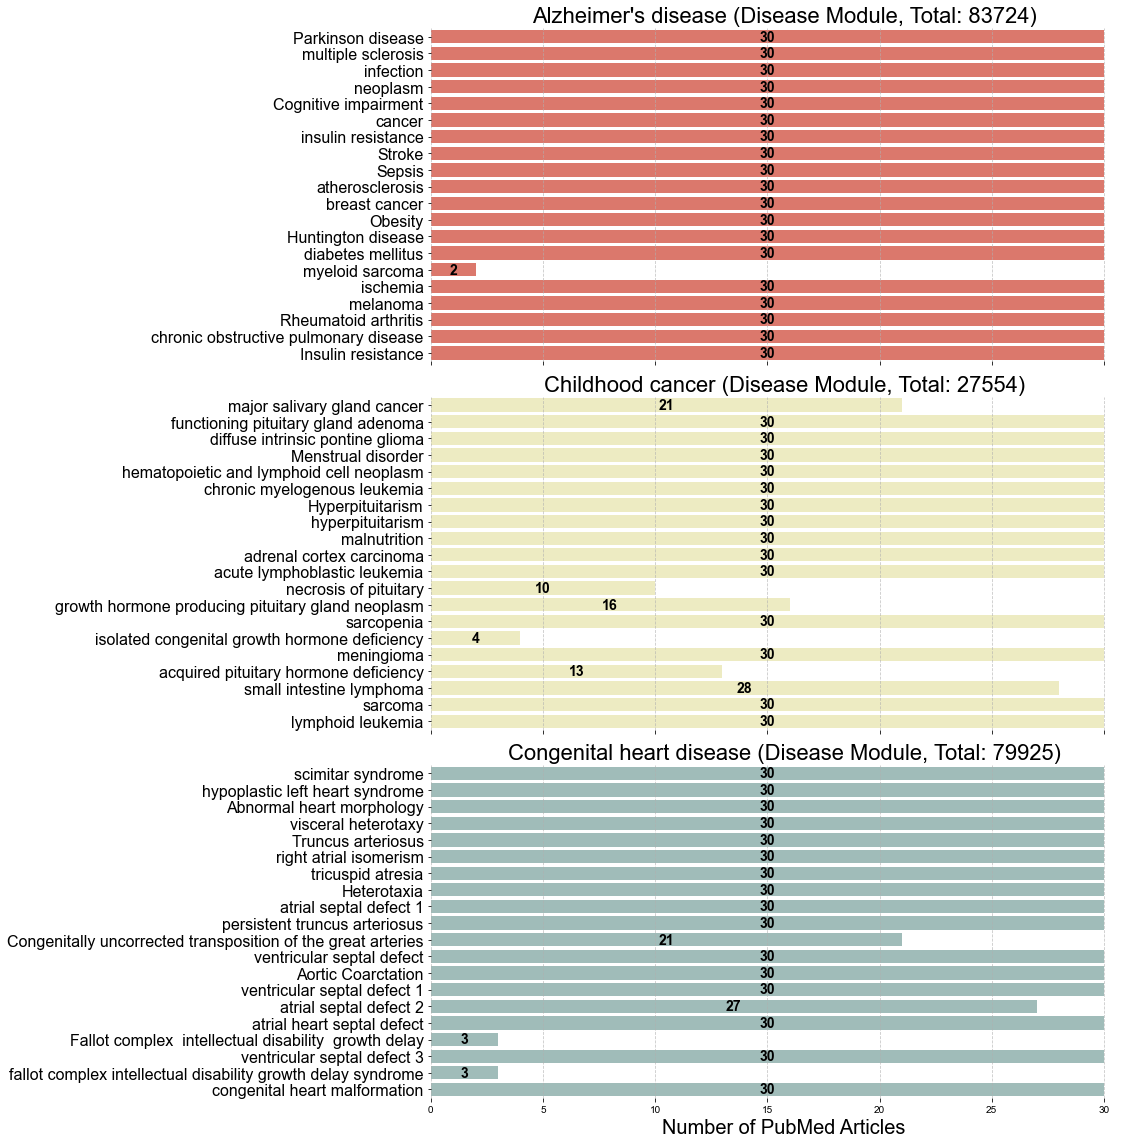

Alzheimer's disease --------------------------------------------------------------------------------
Childhood cancer --------------------------------------------------------------------------------
Congenital heart disease --------------------------------------------------------------------------------


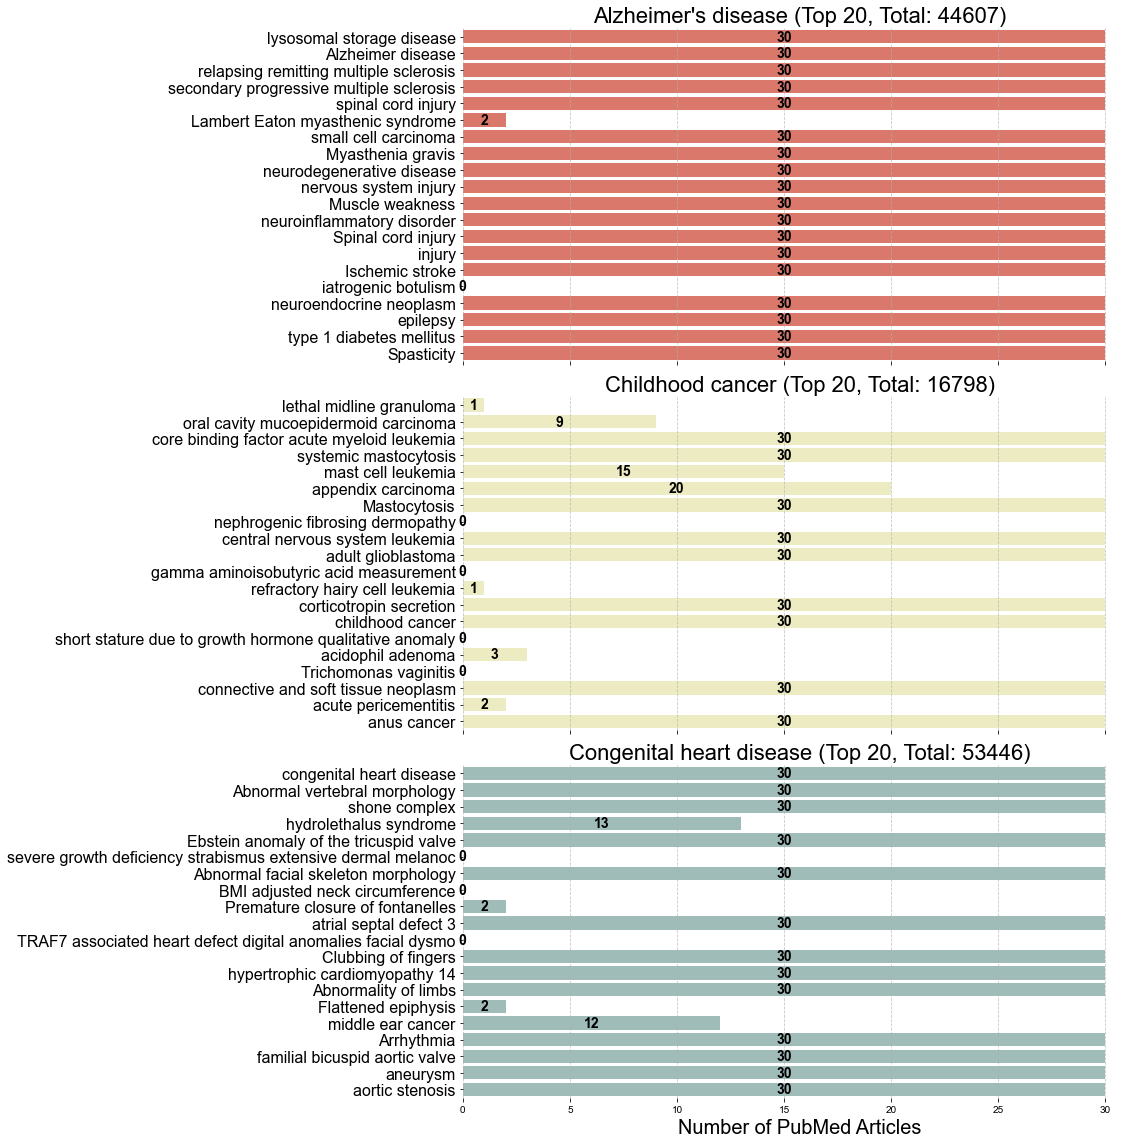

Alzheimer's disease --------------------------------------------------------------------------------
Childhood cancer --------------------------------------------------------------------------------
Congenital heart disease --------------------------------------------------------------------------------


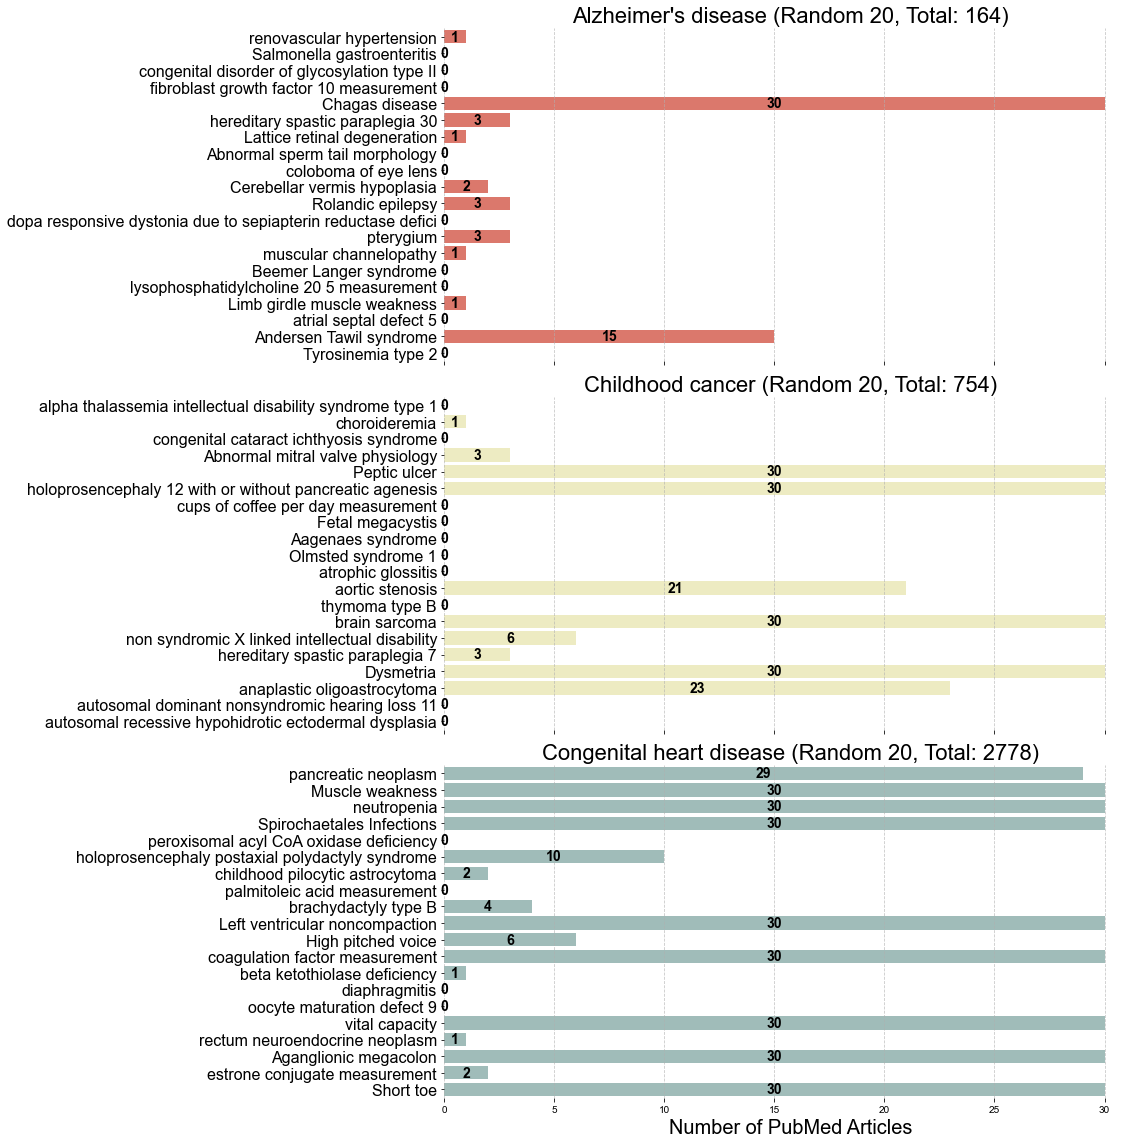

✅ Visualization complete.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

TOP_DISEASE_NUM = 20
plt.rcParams['font.family'] = 'Arial'

# Visualization
for csv_files, info in zip(all_files, subset):
    fig, axes = plt.subplots(3, 1, figsize=(16, 16), sharex=True)
    colors = ['#ed6a5a', '#f4f1bb', '#9bc1bc']

    for i, (explored_disease, path) in enumerate(csv_files.items()):
        ax = axes[i]

        # Load results from CSV
        sufix = ''  #'_1000' if info != 'Disease_module' else ''
        disname = explored_disease.replace(' ', '_')#.replace('\'s', '')
        df_results = pd.read_csv(f"{disname}_pubmed_results_nolit_{info}{sufix}.csv").head(TOP_DISEASE_NUM)

        # Get total number of articles
        top_total = df_results["Articles"].sum()
        df_results.loc[:, 'Articles'] = df_results['Articles'].apply(lambda x: 30 if x > 30 else x)

        # Plot results
        sns.barplot(data=df_results, x="Articles", y="Disease", color=colors[i], ax=ax)
        ax.set_xlabel("Number of PubMed Articles", size=20)
        ax.set_ylabel(None)
        ax.grid(axis="x", linestyle="--", alpha=0.7)
        ax.set_yticks(ax.get_yticks())  # Ensure ticks are set before setting labels
        ax.set_yticklabels([x[:60] for x in df_results['Disease']], size=16)
        ax.set_frame_on(False)

        if info == 'Disease_module':
            ax.set_title(f"{explored_disease} (Disease Module, Total: {top_total})", size=22)
        elif info == 'Top':
            ax.set_title(f"{explored_disease} (Top {TOP_DISEASE_NUM}, Total: {top_total})", size=22)
        else:  # Random subset
            ax.set_title(f"{explored_disease} (Random {TOP_DISEASE_NUM}, Total: {top_total})", size=22)

        # Add value labels
        for p in ax.patches:
            width = p.get_width()
            ax.text(width / 2, p.get_y() + p.get_height() / 2, f'{int(width)}',
                    ha='center', va='center', fontsize=14, color='black', fontweight='bold')

        print(explored_disease, '-' * 80)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f"pubmed_results_nolit_{info}.png", dpi=200)
    plt.show()

print("✅ Visualization complete.")


Alzheimer's disease --------------------------------------------------------------------------------
Total articles for Top: 712365
Total articles for Random: 163325
Childhood cancer --------------------------------------------------------------------------------
Total articles for Top: 504835
Total articles for Random: 109509
Congenital heart disease --------------------------------------------------------------------------------
Total articles for Top: 740394
Total articles for Random: 176331


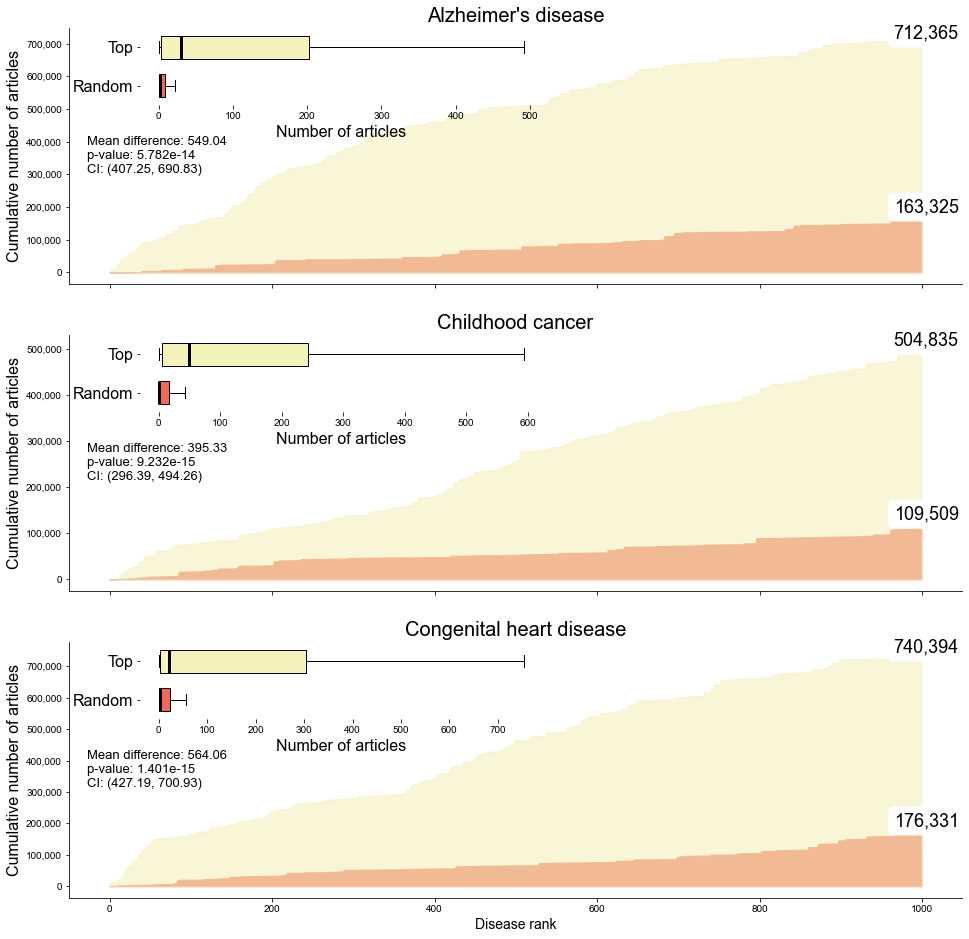

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

# Set the font to Arial for everything
plt.rcParams['font.family'] = 'Arial'

fig, axes = plt.subplots(3, 1, figsize=(16, 16), sharex=True)
random_color = '#ed6a5a'
top_color = '#f4f1bb'
for i, explored_disease in enumerate(csv_files.keys()):
    print(explored_disease, '-'*80)
    df_all = pd.DataFrame()
    ax = axes[i]
    
    # Stacked plot for Top and Random
    for info in ['Top', 'Random']:
        disname = explored_disease.replace(' ', '_')#.replace('\'s', '')
        df_results = pd.read_csv(f"{disname}_pubmed_results_nolit_{info}.csv")
        df_all[info] = df_results['Articles']
        
        # Get total number of articles
        total_articles = df_results["Articles"].sum()
        print(f"Total articles for {info}: {total_articles}")
        
        # Annotate the total number of articles for each category (Top/Random)
        ax.annotate(f"{total_articles:,}", 
                    xy=(0.96, 0.98 if info == 'Top' else 0.3), 
                    xycoords="axes fraction", 
                    ha="center", 
                    va="center", 
                    fontsize=18, 
                    color='black', 
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
    
    df_all['Top_Cumulative'] = df_all['Top'].cumsum()
    df_all['Random_Cumulative'] = df_all['Random'].cumsum()
    
    # Fill between for stacked plot
    ax.fill_between(df_all.index, 0, df_all['Random_Cumulative'], color=random_color, alpha=1.0, label="Random")
    ax.fill_between(df_all.index, 0, df_all['Top_Cumulative'], color=top_color, alpha=0.6, label="Top")

    formatter = FuncFormatter(lambda x, _: f"{x:,.0f}")
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylabel('Cumulative number of articles', size=16)
    
    # *************** Create horizontal boxplots inside each subplot
    ax_inset = ax.inset_axes([0.08, 0.7, 0.45, 0.3])  # Positioning the inset boxplot (x, y, width, height)
    
    # Plot the boxplots with wider boxes
    box = ax_inset.boxplot([df_all['Random'], df_all['Top']], vert=False, patch_artist=True, showfliers=False,
                           widths=0.6,  # Make boxes wider (adjust as needed)
                           medianprops=dict(color='black', linewidth=3))  # Median line color
    ax_inset.spines['top'].set_visible(False)
    ax_inset.spines['right'].set_visible(False)
    ax_inset.spines['left'].set_visible(False)
    ax_inset.spines['bottom'].set_visible(False)
    
    # Color the boxes manually
    box['boxes'][1].set_facecolor(top_color)  # Top box color
    box['boxes'][0].set_facecolor(random_color)  # Random box color
    # Adding labels for the boxplot
    ax_inset.set_yticklabels(['Random', 'Top'], size=16)
    ax_inset.set_xlabel("Number of articles", size=16)
    # *******************************************************************

    # T-test between Top and Random distributions
    t_stat, p_value = stats.ttest_ind(df_all['Top'], df_all['Random'], equal_var=False)
    
    # Calculate Confidence Interval for the difference in means
    mean_diff = np.mean(df_all['Top']) - np.mean(df_all['Random'])
    std_diff = np.sqrt(np.var(df_all['Top'], ddof=1) / len(df_all['Top']) + np.var(df_all['Random'], ddof=1) / len(df_all['Random']))
    ci_low = mean_diff - 1.96 * std_diff
    ci_high = mean_diff + 1.96 * std_diff

    # Display Mean Difference, p-value, and Confidence Interval on the plot
    ax.annotate(f"Mean difference: {mean_diff:.2f}\np-value: {p_value:.3e}\nCI: ({ci_low:.2f}, {ci_high:.2f})", 
                xy=(0.02, 0.50), 
                xycoords="axes fraction", 
                ha="left", 
                va="center", 
                fontsize=13, 
                color='black', 
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
    
    ax.set_title(explored_disease, size=20)
    # Remove legend
    ax.legend().set_visible(False)

# Remove the box around the subplots
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.xlabel("Disease rank", size=14)
plt.savefig(f"pubmed_cum_results_nolit_{info}.png", dpi=200, bbox_inches='tight')
plt.show()
